Due to the small amount of time allowed to solve the problem (3 to 4 hours), management of resources is crucial. Therefore, I will take as a base the **Machine Learning Project Checklist** suggested by Aurelien Geròn in Appendix B of the book *Hands-On Machine Learning with Sci-kit-Learn, Keras and Tensorflow*. Some changes will be made, but the spirit of organization will remain the same.

Most of the comments written in all notebooks were edited after the actual development for readability purposes...

# Frame the problem and look at the big picture


1. The goal is to provide a valuation of the diamonds stolen from the bank.

2. The solution will be used to validate Krenk's claim on the value of the diamonds.

3. It seems there are not current solutions to the problem.

4. The main task is of supervised nature: we are given a *not-so-huge* dataset with characteristics of other diamonds and their value in order to estimate the price- of those stolen.

5. The performance measure can be given by a quadratic loss function. Nonetheless, likely ranges instead of point estimates might be sensible.

6. A small value of the quadratic loss would imply that our predictions are not very far away from the real ones.

7. It's unclear what's the minimum performance needed to reach the valuation objective. We only have the *common sense* golden rule: the more accurate, the better.

8. Since we will be solving a supervised problem where the target variable is continuous, we can borrow ideas and concepts from Regression techniques.

9. There's no human expertise available. But we can always ask google about diamond details if needed.

10. If I had to solve the valuation problem manually, I would ask google what's the most important feature in a diamond and try to look for the most similar diamond in the database according to the feature and use its value as a proxy for the price. This suggest that instance-based learning can be useful (regresion trees from this particular example).

11. The main assumptions are 
    - The given features of the diamonds mostly determine their value. 
    - The value presented in the database is close to their current value.

12. Since we don't have communication with Krenk or anybody, the verification of the assumptions is unfeasible.

# Get the data

The data of the stolen diamonds was copied from the e-mail to the file `Gringotts_diamonds.csv`, for easier transportation.

The *not-so-big* database was sent in a zip file, we must extract it...

In [1]:
# Library
import zipfile
import os

# Indicate path of zip file
path_zip = 'diamonds.zip'
outdir = '.'
# Extraction...
with zipfile.ZipFile(path_zip, 'r') as zip_ref:
    zip_ref.extractall(outdir)
# Print names of the files
arr = os.listdir(outdir)
print(arr)

['Client presentation.pdf', '.ipynb_checkpoints', 'coords_diamonds.csv', 'diamonds.csv', 'diamonds.zip', 'Gringotts_diamonds.csv', 'Speaker notes - client presentation.pdf']


The new files are `diamonds.csv` and `coords_diamonds.csv`. Now we must get to know its size to determine the ideal tool to work with


In [2]:
# Library
import os

filenames = ['diamonds.csv',
             'coords_diamonds.csv']

for file in filenames:
    # Read size in bytes
    size = os.stat(file).st_size
    # 1Gb = 1024Mb, 1Mb = 1024b
    print(f'File: {file}, Size: {size/1048576} MB')

File: diamonds.csv, Size: 2.7328596115112305 MB
File: coords_diamonds.csv, Size: 1.440389633178711 MB


Since they are of the order of MB, we can open them with `pandas` and work on memory. We can even use `Excel` or `LibreOffice` to see how it looks like. We learn that

1. The data has some weird characters, for example, in the `cut` column we have `Premium` and `&Premium`.
2. The `longitude ` column in the coords file has an extra space

Now we can open the data.

In [3]:
# Data management and computation
import numpy as np
import pandas as pd

# Read databases, considering that the first column is just an index
Gringotts_diamonds = pd.read_csv('Gringotts_diamonds.csv', index_col=0, encoding='utf8')
diamonds = pd.read_csv('diamonds.csv', index_col=0, encoding='utf8')
coords_diamonds = pd.read_csv('coords_diamonds.csv', index_col=0, names=['latitude','longitude'], encoding='utf8')

In [4]:
# Print data head to see how it is stored
Gringotts_diamonds.head(10)

,Carat,Cut,Color,Clarity,Depth,Table,x,y,z,coordinates
1,0.71,Good,I,VVS2,63.1,58.0,5.64,5.71,3.58,"35.02636, -114.38351"
2,0.83,Ideal,G,VS1,62.1,55.0,6.02,6.05,3.75,"35.00350, -109.78961"
3,0.50,Ideal,E,VS2,61.5,55.0,5.11,5.16,3.16,"35.10544, -106.669673"
4,0.39,Premium,J,VS1,61.6,59.0,4.67,4.71,2.89,"34.94666, -104.64730"
5,0.32,Premium,G,VS1,62.1,56.0,4.43,4.40,2.74,"35.18864, -101.98602"
6,0.90,Good,F,SI2,63.3,57.0,6.08,6.14,3.87,"35.26611, -99.63874"
7,0.51,Ideal,D,VS1,60.9,57.0,5.20,5.17,3.16,"35.51572, -97.67080"
8,1.12,Ideal,G,VVS2,62.1,54.8,6.64,6.66,4.13,"36.163605, -95.75950"
9,0.40,Ideal,G,VVS2,62.4,56.0,4.72,4.74,2.95,"37.689186, -92.6473"
10,0.36,Premium,I,VS2,62.7,59.0,4.54,4.58,2.86,"38.66303, -90.21808"


In [5]:
diamonds.head(10)

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75
5,0.24,Very Good,J,VVS2,62.8,57.0,336,3.94,3.96,2.48
6,0.24,Very Good,I,VVS1,62.3,57.0,336,3.95,3.98,2.47
7,0.26,Very Good,H,SI1,61.9,55.0,337,4.07,4.11,2.53
8,0.22,Fair,E,VS2,65.1,61.0,337,3.87,3.78,2.49
9,0.23,Very Good,H,VS1,59.4,61.0,338,4.00,4.05,2.39


In [6]:
coords_diamonds.head(10)

,latitude,longitude
NaN,latitude,longitude
0.0,39.8813889,-83.0930556
1.0,33.4150000,-111.5488889
2.0,40.1672222,-105.1013889
3.0,37.3711111,-85.5830556
4.0,48.5394444,-121.745
5.0,38.7705556,-81.5533333
6.0,35.5780556,-108.3213889
7.0,53.916667,-122.766667
8.0,33.3869444,-84.2830556


I would like to ask if the coordinates are in exact correspondence with the features via the index. I will operate such as if that was the case...

In [7]:
# Extract latitude and longitude of Gringotts diamonnds
Gringotts_diamonds[['latitude','longitude']] = Gringotts_diamonds['coordinates'].str.split(',',expand=True).astype('float')
del(Gringotts_diamonds['coordinates'])

# Mantain capital letter at the beginning for the other diamonds
diamonds.columns = [name.capitalize() if name not in ['x','y','z'] else name for name in diamonds.columns]
# Join with coordinates
diamonds = diamonds.join(coords_diamonds,)
# Set aside the target variable
Diamonds_Y = diamonds['Price']
del(diamonds['Price'])
# Set aside the feature variables
Diamonds_X = diamonds[Gringotts_diamonds.columns]

In [8]:
# See the data 1/3
Diamonds_X

,Carat,Cut,Color,Clarity,Depth,Table,x,y,z,latitude,longitude
0,0.23,Ideal,E,SI2,61.5,55.0,3.95,3.98,2.43,39.8813889,-83.0930556
1,0.21,Premium,E,SI1,59.8,61.0,3.89,3.84,2.31,33.4150000,-111.5488889
2,0.23,Good,E,VS1,56.9,65.0,4.05,4.07,2.31,40.1672222,-105.1013889
3,0.29,Premium,I,VS2,62.4,58.0,4.20,4.23,2.63,37.3711111,-85.5830556
4,0.31,Good,J,SI2,63.3,58.0,4.34,4.35,2.75,48.5394444,-121.745
...,...,...,...,...,...,...,...,...,...,...,...
53925,0.72,Ideal,D,SI1,60.8,57.0,5.75,5.76,3.50,38.5816667,-121.4933333
53926,0.72,Good,D,SI1,63.1,55.0,5.69,5.75,3.61,32.436381,-111.222442
53927,0.70,Very Good,D,SI1,62.8,60.0,5.66,5.68,3.56,40.2413889,-75.2841667
53928,0.86,Premium,H,SI2,61.0,58.0,6.15,6.12,3.74,38.8222222,-122.7219444


In [9]:
# See the data 2/3
Diamonds_Y

0         326
1         326
2         327
3         334
4         335
         ... 
53925    2757
53926    2757
53927    2757
53928    2757
53929    2757
Name: Price, Length: 53930, dtype: int64

In [10]:
# See the data 3/3
Gringotts_diamonds

,Carat,Cut,Color,Clarity,Depth,Table,x,y,z,latitude,longitude
1,0.71,Good,I,VVS2,63.1,58.0,5.64,5.71,3.58,35.026360,-114.383510
2,0.83,Ideal,G,VS1,62.1,55.0,6.02,6.05,3.75,35.003500,-109.789610
3,0.50,Ideal,E,VS2,61.5,55.0,5.11,5.16,3.16,35.105440,-106.669673
4,0.39,Premium,J,VS1,61.6,59.0,4.67,4.71,2.89,34.946660,-104.647300
5,0.32,Premium,G,VS1,62.1,56.0,4.43,4.40,2.74,35.188640,-101.986020
6,0.90,Good,F,SI2,63.3,57.0,6.08,6.14,3.87,35.266110,-99.638740
7,0.51,Ideal,D,VS1,60.9,57.0,5.20,5.17,3.16,35.515720,-97.670800
8,1.12,Ideal,G,VVS2,62.1,54.8,6.64,6.66,4.13,36.163605,-95.759500
9,0.40,Ideal,G,VVS2,62.4,56.0,4.72,4.74,2.95,37.689186,-92.647300
10,0.36,Premium,I,VS2,62.7,59.0,4.54,4.58,2.86,38.663030,-90.218080


Now we can save the files

In [11]:
# Create folder if it doesn't exists
out_path = 'Databases'
if not os.path.exists(out_path):
    os.mkdir(out_path)
Gringotts_diamonds.to_csv(os.path.join(out_path,'Gringotts.csv'))
Diamonds_X.to_csv(os.path.join(out_path,'Diamonds_X.csv'))
Diamonds_Y.to_csv(os.path.join(out_path,'Diamonds_Y.csv'))

# Sample a test set

Now, I will deviate from Géron's path, since I think that understanding the columns will help in creating a sensible test set.

1. According to [this website](https://www.diamonds.pro/education/cuts/), *The most important factor in a diamond’s value and price is its Cut quality*. Also *The GIA diamond cut chart grades Diamond Cut on the scale of Ideal, Excellent, Very Good, Good, Fair and Poor* [(see this)](https://www.diamonds.pro/education/4cs-diamonds/).
2. Sime explanations are given in the same website about the depth width and table, it seems that their relationship is complicated.
3. Stop references... You get the point. Diamonds grade from D to Z, with D being the most colorless and expensive.
4. The clarity chart is, in decreasing order
    - FL (Flawless)
    - IF (Internally Flawless)
    - VVS1 (Very, Very Slightly Included 1)
    - VVS2 (Very, Very Slightly Included 2)
    - VS1 (Very Slightly Included 1)
    - VS2 (Very Slightly Included 2)
    - SI1 (Slightly Included 1)
    - SI2 (Slightly Included 2)
    - I1 (Inclusions 1)
    - I2 (Inclusions 2)
5. Carat refers to the weight of the diamond. *While Carat weight is an element to consider when buying a diamond, the overall appearance and brilliance should carry more importance.* 

Some cleaning is evident now and some charts will come in handy

### Clean the Cut column

In [12]:
Diamonds_X['Cut'].unique()

array(['Ideal', 'Premium', 'Good', 'Very Good', 'Fair', 'Very Goo!d',
       "P*'remium", 'I#deal', '#Very Good', 'P?remium', "*'Ideal",
       '!Good', 'Pre!mium', 'Pr?emium', 'Very Go#od', 'Ide&al', 'Ide!al',
       'Id!eal', '&Premium', 'Go?od', 'G#ood', "Very *'Good", "Ide*'al",
       'V&ery Good', '&Ideal', 'Very G#ood'], dtype=object)

In [13]:
## Translation to eliminate unwanted characters
# mapping
trans_dict ={'!':'','*':'',"'":'','#':'','?':'','&':''}
# creating translate table from dictionary
trans_table ="!*'#?&".maketrans(trans_dict)
  
# translating through passed transtable
Diamonds_X['Cut'].str.translate(trans_table).unique()

array(['Ideal', 'Premium', 'Good', 'Very Good', 'Fair'], dtype=object)

In [14]:
Diamonds_X['Cut'] = Diamonds_X['Cut'].str.translate(trans_table)

### Clean the Color column

In [15]:
Diamonds_X['Color'].unique()

array(['E', 'I', 'J', 'H', 'F', 'G', 'D', "*'E", '#F', '&G', '!H', '?J',
       '#D', '&I', '!I', '?G', '#H', '?H', '?E', "*'F", '!E', '&F', '#G',
       "*'I", '!F', '&E'], dtype=object)

In [16]:
# The same solution will work
Diamonds_X['Color'] = Diamonds_X['Color'].str.translate(trans_table)

In [17]:
Diamonds_X['Color'].unique()

array(['E', 'I', 'J', 'H', 'F', 'G', 'D'], dtype=object)

### Clean the Clarity column

In [18]:
Diamonds_X['Clarity'].unique()

array(['SI2', 'SI1', 'VS1', 'VS2', 'VVS2', 'VVS1', 'I1', 'IF', 'S?I1',
       'SI!1', '&VS2', '&SI2', "S*'I1", 'VS?1', "S*'I2", '#VS1', 'V&S2',
       'V!S2', '!VS2', 'VS#2', "VVS*'2", "*'SI2", 'VV?S1', 'S&I1',
       "*'SI1", 'SI?1', 'VV#S1', 'V#S2', '#SI!1', 'S!I2'], dtype=object)

In [19]:
# The same solution will work
Diamonds_X['Clarity'] = Diamonds_X['Clarity'].str.translate(trans_table)

In [20]:
Diamonds_X['Clarity'].unique()

array(['SI2', 'SI1', 'VS1', 'VS2', 'VVS2', 'VVS1', 'I1', 'IF'],
      dtype=object)

## See if Stratified sampling is sensible

In [21]:
# Inform pandas that some categories are ordered

Diamonds_X['Color'] = pd.Categorical(Diamonds_X['Color'], ordered=True,
                   categories=['D','E','F','G','H','I','J'][::-1])
Diamonds_X['Cut'] = pd.Categorical(Diamonds_X['Cut'], ordered=True,
                   categories=['Ideal', 'Premium', 'Very Good', 'Good', 'Fair'][::-1])
Diamonds_X['Clarity'] = pd.Categorical(Diamonds_X['Clarity'], ordered=True,
                   categories=['FL','IF','VVS1','VVS2','VS1','VS2','SI1','SI2','I1','I2'][::-1])

In [22]:
Diamonds_X['Cut']

0            Ideal
1          Premium
2             Good
3          Premium
4             Good
           ...    
53925        Ideal
53926         Good
53927    Very Good
53928      Premium
53929        Ideal
Name: Cut, Length: 53930, dtype: category
Categories (5, object): ['Fair' < 'Good' < 'Very Good' < 'Premium' < 'Ideal']

In [23]:
# Count the number of registers across categories
counts = Diamonds_X.groupby(['Cut','Color','Clarity']).size().unstack()

In [24]:
counts

Clarity          I2  I1  SI2  SI1   VS2  VS1  VVS2  VVS1   IF  FL
Cut       Color                                                  
Fair      J       0  23   27   28    23   16     1     1    0   0
          I       0  34   45   30    32   25     8     1    0   0
          H       0  52   91   75    41   32    11     1    0   0
          G       0  53   80   69    45   45    17     3    2   0
          F       0  35   89   83    53   33    10     5    4   0
          E       0   9   78   65    42   14    13     3    0   0
          D       0   4   56   58    25    5     9     3    3   0
Good      J       0   4   53   88    90   52    13     1    6   0
          I       0   9   81  165   110  103    25    22    6   0
          H       0  14  158  235   138   77    45    31    4   0
          G       0  19  163  207   192  152    75    41   22   0
          F       0  19  200  273   184  132    50    35   15   0
          E       0  23  202  355   160   89    52    43    9   0
          D       0   8  223  237   104   43    25    13    9   0
Very Good J       0   8  128  182   184  120    29    19    8   0
          I       0   8  200  358   274  205    71    69   19   0
          H       0  12  343  547   376  257   145   115   29   0
          G       0  16  327  474   479  432   302   190   79   0
          F       0  13  343  559   466  293   249   174   67   0
          E       0  22  445  626   503  293   298   170   43   0
          D       0   5  314  494   309  175   141    52   23   0
Premium   J       0  13  161  209   202  152    34    24   12   0
          I       0  24  312  367   314  221    82    84   23   0
          H       0  46  521  655   532  336   118   112   40   0
          G       0  46  492  566   721  565   275   171   87   0
          F       0  34  523  608   619  290   146    80   31   0
          E       0  30  519  614   629  292   121   105   27   0
          D       0  12  421  556   339  131    94    40   10   0
Ideal     J       0   2  110  243   232  201    54    29   25   0
          I       0  17  274  504   438  408   178   179   95   0
          H       0  38  450  763   556  467   289   326  226   0
          G       0  16  486  660   910  952   772   594  491   0
          F       0  42  453  608   879  616   520   440  268   0
          E       0  18  469  766  1135  593   507   335   79   0
          D       0  13  356  738   920  350   284   144   28   0

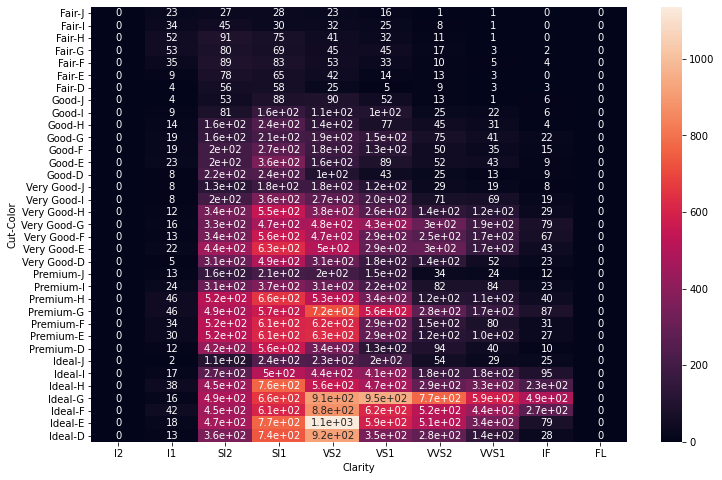

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))
sns.heatmap(counts, annot=True)
plt.show()

In [26]:
counts = Gringotts_diamonds.groupby(['Cut','Color','Clarity']).size().unstack()

In [27]:
counts

Clarity        SI2  VS1  VS2  VVS2
Cut     Color                     
Good    F      1.0  NaN  NaN   NaN
        I      NaN  NaN  NaN   1.0
Ideal   D      NaN  1.0  NaN   NaN
        E      NaN  NaN  1.0   NaN
        G      NaN  1.0  NaN   2.0
Premium G      NaN  1.0  NaN   NaN
        I      NaN  NaN  1.0   NaN
        J      NaN  1.0  NaN   NaN

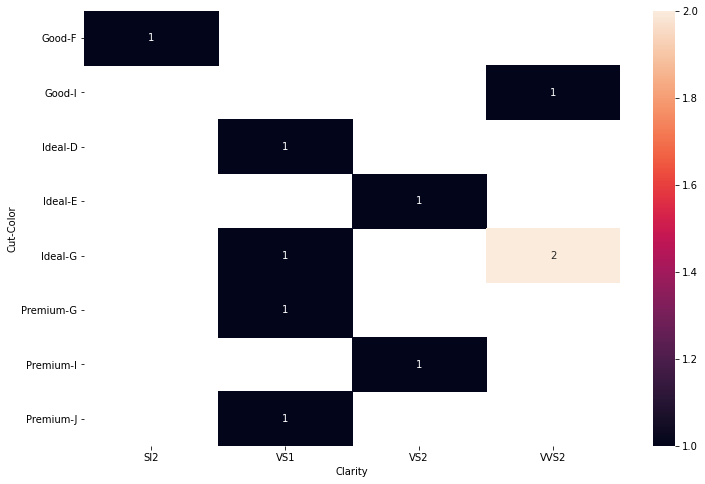

In [28]:
plt.figure(figsize=(12,8))
sns.heatmap(counts, annot=True)
plt.show()

In order to save time, we perform simple random sampling from our data...

In [29]:
# Library
from sklearn.model_selection import train_test_split

# Set aside 20$ of data for validation
X_train, X_test, y_train, y_test = train_test_split(Diamonds_X, Diamonds_Y, 
                                                    test_size=0.2, random_state=42)

See the impact in class balance...

In [30]:
for item in Gringotts_diamonds[['Cut','Color','Clarity']].values:
    print(Diamonds_X[(Diamonds_X['Cut']==item[0]) & (Diamonds_X['Color']==item[1]) & (Diamonds_X['Clarity']==item[2])].size/len(Diamonds_X))

0.005099202670127943
0.1941776376784721
0.23150380122380865
0.031003152234377898
0.11524198034489153
0.040793621361023547
0.0713888373817912
0.1574633784535509
0.1574633784535509
0.06404598553680697


In [31]:
for item in Gringotts_diamonds[['Cut','Color','Clarity']].values:
    print(X_train[(X_train['Cut']==item[0]) & (X_train['Color']==item[1]) & (X_train['Clarity']==item[2])].size/len(X_train))

0.0053541628036343405
0.1912201001297979
0.2264045985536807
0.03136009642128686
0.11167253847580197
0.040283701094010756
0.0729185981828296
0.16113480437604302
0.16113480437604302
0.06246523270906731


For me it doesn't seem that the particular classes were affected in a dramatic way, so we can proceed. 

In [32]:
X_train.to_csv(os.path.join(out_path,'X_train.csv'))
X_test.to_csv(os.path.join(out_path,'X_test.csv'))
y_train.to_csv(os.path.join(out_path,'y_train.csv'))
y_test.to_csv(os.path.join(out_path,'y_test.csv'))